In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn.nn.models.v2106.gate_points_networks import SimpleNetwork
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list

# data pre-processing and visualization
import numpy as np
import matplotlib.pyplot as plt

# utilities
import time
from tqdm import tqdm
from utils import *

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [25]:
# reload a module without kernel restart
from importlib import reload
import sys
reload(sys.modules['utils'])
from utils import *

In [3]:
# load data
df, species = load_data('data.csv')
df.head()

parsing cif files ...


100%|██████████| 1521/1521 [00:00<00:00, 11330.24it/s]                          


,mp_id,structure,phfreq,phdos,pdos,formula,species
0,mp-1000,"(Atom('Ba', [0.0, 0.0, 0.0], index=0), Atom('T...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.1603814665137704, 0.366293016390463, 0...","{'Ba': [0.0, 0.17004785173719497, 0.4321591874...",BaTe,"[Te, Ba]"
1,mp-1002124,"(Atom('Hf', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.02337731725373556, 0.030910686260937723, 0....","{'Hf': [0.026541048236378005, 0.03587084551615...",CHf,"[C, Hf]"
2,mp-1002164,"(Atom('Ge', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0017221473876927959, 0.005981246148731...","{'Ge': [0.0, 0.00316167053214679, 0.0109190651...",CGe,"[C, Ge]"
3,mp-10044,"(Atom('B', [4.440892098500626e-16, 6.194849927...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.002277293012378372, 0.0078646582782471...","{'B': [0.0, 0.00029269193672558846, 0.00105324...",AsB,"[As, B]"
4,mp-1008223,"(Atom('Ca', [0.0, 0.0, 0.0], index=0), Atom('S...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.258870972416879, 0.5505201512544314, 0...","{'Ca': [0.0, 0.11150000312651394, 0.2215562000...",CaSe,"[Se, Ca]"


Structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

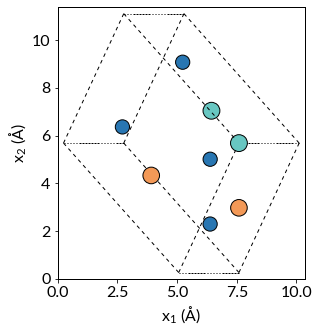

In [4]:
# example structure
i = 12
struct = df.iloc[i]['structure']
fig, ax = plt.subplots(figsize=(6,5))
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,90y,0z'))
ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');

split train/dev ...


100%|██████████| 64/64 [00:00<00:00, 343.80it/s]                                


split valid/test ...


100%|██████████| 62/62 [00:00<00:00, 439.23it/s]                                


number of training examples: 1192
number of validation examples: 137
number of testing examples: 192
total number of examples: 1521


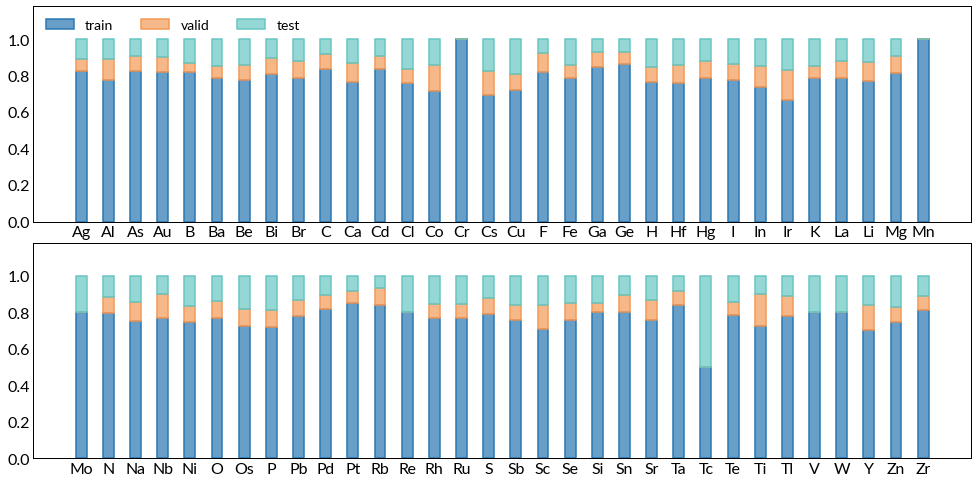

In [5]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=0.1, test_size=0.1, seed=12, plot=True)

In [6]:
# one-hot encoding atomic mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z
    specie_am.append(specie.mass)

type_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 234340.85it/s]                           


In [7]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->j', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))
    
    # compute edge lengths
    edge_len = np.around(np.sqrt((edge_vec**2).sum(dim=1).numpy()), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=type_onehot[[type_encoding[specie] for specie in symbols]],
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )
    
    return data

r_max = 5 # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1521/1521 [00:13<00:00, 112.15it/s]                            


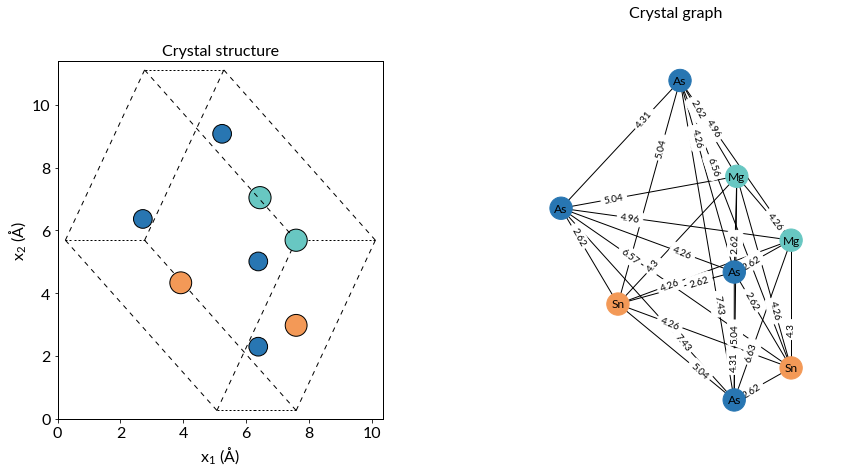

In [8]:
plot_example(df, i=12, label_edges=True)

In [9]:
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 30.022166361974406 / 29.264765784114054 / 28.156626506024097


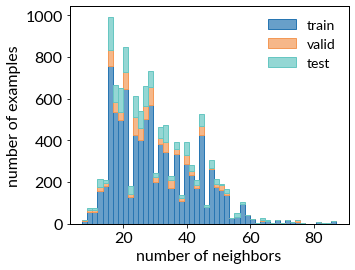

In [10]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

In [11]:
class SimplePeriodicNetwork(SimpleNetwork):
    def __init__(self, in_dim, em_dim, **kwargs):
        # override the `pool_nodes` keyword of SimpleNetwork to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['pool_nodes'] == True:
            kwargs['pool_nodes'] = False
            kwargs['num_nodes'] = 1.
            self.pool = True
        super().__init__(**kwargs)

        # embed the mass-weighted one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    # overwrite the preprocess method of SimpleNetwork to adapt for periodic boundary data
    def preprocess(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        edge_src = data['edge_index'][0]  # edge source
        edge_dst = data['edge_index'][1]  # edge destination
        edge_vec = data['edge_vec']
        
        return batch, data['x'], edge_src, edge_dst, edge_vec

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # if pool_nodes was set to True, use scatter_mean to aggregate
        data.x = F.relu(self.em(data.x))
        output = super().forward(data)
        
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # Take mean over atoms per example
        
        output = F.relu(output)
        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))
        return output

In [33]:
out_dim = len(df.iloc[0]['phfreq'])
em_dim = 64

model = SimplePeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",    # one-hot scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",  # out_dim scalars (L=0 and even parity) to output
    lmax=1,                         # maximum order of spherical harmonics
    mul=32,                         # multiplicity of irreducible representations
    layers=2,                       # number of nonlinearities (number of convolutions = layers + 1)
    num_neighbors=n_train.mean(),   # scaling factor based on the typical number of neighbors
    max_radius=r_max,               # cutoff radius for convolution
    pool_nodes=True,
)

print(model)

SimplePeriodicNetwork(
  (mp): MessagePassing(
    (layers): ModuleList(
      (0): Compose(
        (first): Convolution(
          (sc): FullyConnectedTensorProduct(64x0e x 1x0e -> 64x0e+32x1o | 4096 paths | 4096 weights)
          (lin1): FullyConnectedTensorProduct(64x0e x 1x0e -> 64x0e | 4096 paths | 4096 weights)
          (fc): FullyConnectedNet[10, 100, 128]
          (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
          (lin2): FullyConnectedTensorProduct(64x0e+64x1o x 1x0e -> 64x0e+32x1o | 6144 paths | 6144 weights)
          (alpha): FullyConnectedTensorProduct(64x0e+64x1o x 1x0e -> 1x0e | 64 paths | 64 weights)
        )
        (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
      )
      (1): Compose(
        (first): Convolution(
          (sc): FullyConnectedTensorProduct(32x0e+32x1o x 1x0e -> 96x0e+32x1o+32x1e | 4096 paths | 4096 weights)
          (lin1): FullyConnectedTensorProduct(32x0e+32x1o x 1x0e -> 32x0e+32x1o | 2048 paths | 2048 

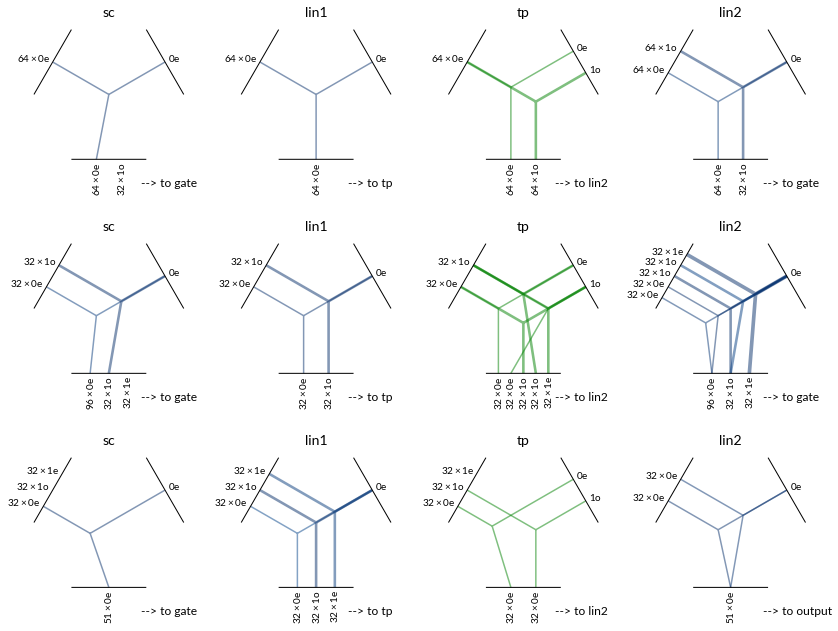

In [34]:
# visualize tensor products of the model
visualize_layers(model)

In [35]:
opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [36]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

run_name = 'model_' + time.strftime("%y%m%d", time.localtime())
#run_name = 'model_211109'
print(run_name)

torch device: cuda:6
model_211109


In [37]:
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
      max_iter=21, scheduler=scheduler, device=device)

100%|██████████| 1192/1192 [01:00<00:00, 19.83it/s]                             


Iteration    1   train loss =   0.0534   valid loss =   0.0518   elapsed time = 00:01:00


100%|██████████| 1192/1192 [00:55<00:00, 21.47it/s]                             


Iteration    2   train loss =   0.0441   valid loss =   0.0444   elapsed time = 00:02:06


100%|██████████| 1192/1192 [00:55<00:00, 21.59it/s]                             


Iteration    3   train loss =   0.0387   valid loss =   0.0395   elapsed time = 00:03:12


100%|██████████| 1192/1192 [00:59<00:00, 20.11it/s]                             


Iteration    4   train loss =   0.0355   valid loss =   0.0376   elapsed time = 00:04:22


100%|██████████| 1192/1192 [00:55<00:00, 21.38it/s]                             


Iteration    5   train loss =   0.0341   valid loss =   0.0360   elapsed time = 00:05:29


100%|██████████| 1192/1192 [00:54<00:00, 22.00it/s]                             


Iteration    7   train loss =   0.0321   valid loss =   0.0350   elapsed time = 00:07:30


100%|██████████| 1192/1192 [00:55<00:00, 21.40it/s]                             


Iteration    9   train loss =   0.0295   valid loss =   0.0337   elapsed time = 00:09:30


100%|██████████| 1192/1192 [00:54<00:00, 21.85it/s]                             


Iteration   11   train loss =   0.0271   valid loss =   0.0329   elapsed time = 00:11:31


100%|██████████| 1192/1192 [00:55<00:00, 21.32it/s]                             


Iteration   14   train loss =   0.0248   valid loss =   0.0328   elapsed time = 00:14:27


100%|██████████| 1192/1192 [00:54<00:00, 21.79it/s]                             


Iteration   17   train loss =   0.0231   valid loss =   0.0333   elapsed time = 00:17:22


100%|██████████| 1192/1192 [00:54<00:00, 21.98it/s]                             


Iteration   21   train loss =   0.0213   valid loss =   0.0329   elapsed time = 00:21:01


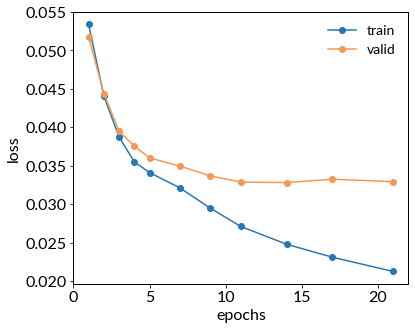

In [38]:
history = torch.load(run_name + '.torch')['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="train", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="valid", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

In [39]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch')['state'])
dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)
        
df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 24/24 [00:00<00:00, 44.65it/s]                                 


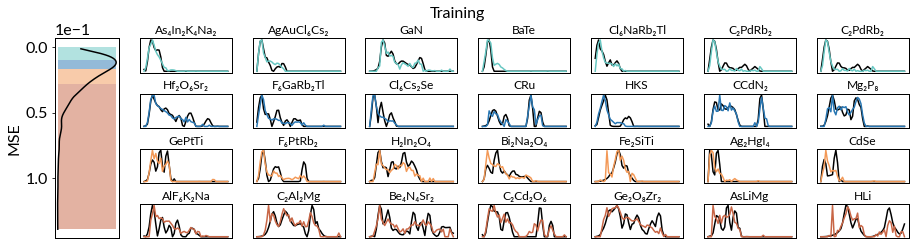

In [40]:
plot_predictions(df, idx_train, 'Training')

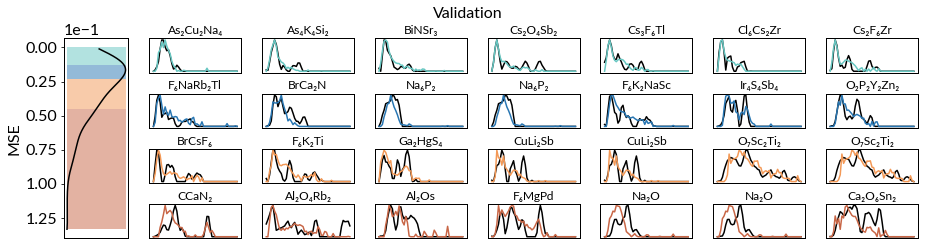

In [41]:
plot_predictions(df, idx_valid, 'Validation')

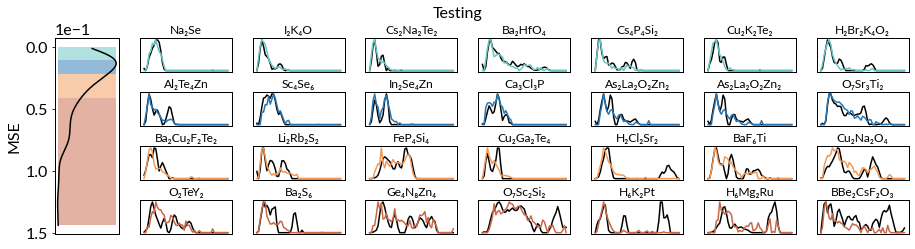

In [42]:
plot_predictions(df, idx_test, 'Testing')

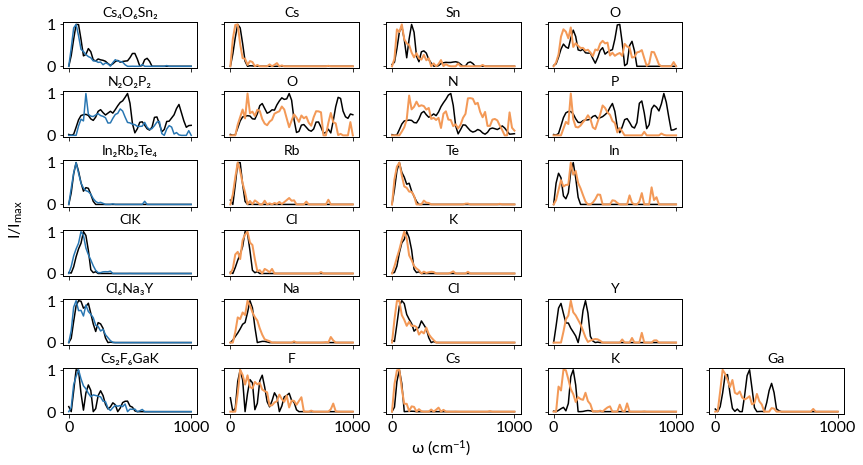

In [43]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch')['state'])
model.pool = False

# plot
plot_partial_predictions(model, df, idx_test, device=device)